In [1]:
# basic packages
import numpy as np
import pandas as pd
import scipy
import pickle
import random
import os

# loading in and transforming data
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import PIL
from PIL import Image
import imageio

# visualizing data
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [136]:
# Paths et cetera
path_save_up_to_5gb = '/kaggle/working/'
path_monet = '/content/drive/MyDrive/ganchanh/data/images/images/Eugene_Delacroix'
path_photo = '/content/drive/MyDrive/ganchanh/gan-getting-started/photo_jpg'
img_size = 256

In [5]:
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [6]:
set_seed(42)

In [7]:
def save_checkpoint(iteration, G_XtoY, G_YtoX, D_X, D_Y, checkpoint_dir='/kaggle/working/'):
    """
    Saves the parameters of both generators and discriminators.
    """
    #Path
    G_XtoY_path = os.path.join(checkpoint_dir, 'G_XtoY.pkl')
    G_YtoX_path = os.path.join(checkpoint_dir, 'G_YtoX.pkl')
    D_X_path = os.path.join(checkpoint_dir, 'D_X.pkl')
    D_Y_path = os.path.join(checkpoint_dir, 'D_Y.pkl')
    #Saving
    torch.save(G_XtoY.state_dict(), G_XtoY_path)
    torch.save(G_YtoX.state_dict(), G_YtoX_path)
    torch.save(D_X.state_dict(), D_X_path)
    torch.save(D_Y.state_dict(), D_Y_path)

In [8]:
def load_checkpoint(checkpoint_path, map_location=None):
    """
    Load checkoint
    """
    #model.load_state_dict(torch.load(checkpoint_path))
    checkpoint = torch.load(checkpoint_path, map_location=map_location)
    print(' [*] Loading checkpoint from %s succeed!' % checkpoint_path)
    return checkpoint

In [9]:
def show_test(fixed_Y, fixed_X, G_YtoX, G_XtoY, mean_=0.5, std_=0.5):
    """
    Shows results of generates based on test image input. 
    """
    #Identify correct device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    #Create fake pictures for both cycles
    fake_X = G_YtoX(fixed_Y.to(device))
    fake_Y = G_XtoY(fixed_X.to(device))
    
    #Generate grids
    grid_x =  make_grid(fixed_X, nrow=4).permute(1, 2, 0).detach().cpu().numpy()
    grid_y =  make_grid(fixed_Y, nrow=4).permute(1, 2, 0).detach().cpu().numpy()
    grid_fake_x =  make_grid(fake_X, nrow=4).permute(1, 2, 0).detach().cpu().numpy()
    grid_fake_y =  make_grid(fake_Y, nrow=4).permute(1, 2, 0).detach().cpu().numpy()
    
    #Normalize pictures to pixel range rom 0 to 255
    X, fake_X = reverse_normalize(grid_x, mean_, std_), reverse_normalize(grid_fake_x, mean_, std_)
    Y, fake_Y = reverse_normalize(grid_y, mean_, std_), reverse_normalize(grid_fake_y, mean_, std_)
    
    #Transformation from X -> Y
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(20, 10))
    ax1.imshow(X)
    ax1.axis('off')
    ax1.set_title('X')
    ax2.imshow(fake_Y)
    ax2.axis('off')
    ax2.set_title('Fake Y  (Monet-esque)')
    plt.show()

In [10]:
class ImageDataset(Dataset):
        """
        Custom dataset
        """
        
        def __init__(self, img_path, img_size=256, normalize=True):
            self.img_path = img_path
            
            if normalize:
                self.transform = transforms.Compose([
                    transforms.Resize(img_size),
                    transforms.CenterCrop(img_size),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.5], std=[0.5])
                ])
            else:
                self.transform = transforms.Compose([
                    transforms.Resize(img_size),
                    transforms.CenterCrop(img_size),
                    transforms.ToTensor()
                ])
            
            #Dictionary entries
            self.img_idx = dict()
            for number_, img_ in enumerate(os.listdir(self.img_path)):
                self.img_idx[number_] = img_
                
        def __len__(self):
            #Length of dataset --> number of images
            return len(self.img_idx)
        
        def __getitem__(self, idx):
            img_path = os.path.join(self.img_path, self.img_idx[idx])
            img = Image.open(img_path)
            img = self.transform(img)
            
            return img

In [11]:
def reverse_normalize(image, mean_=0.5, std_=0.5):
    if torch.is_tensor(image):
        image = image.detach().numpy()
    un_normalized_img = image * std_ + mean_
    un_normalized_img = un_normalized_img * 255
    return np.uint8(un_normalized_img)

In [137]:
#Create datasets
dataset_monet = ImageDataset(path_monet, img_size=256, normalize=True) #monet
dataset_photo = ImageDataset(path_photo, img_size=256, normalize=True) #photo

In [138]:
#Create test loaders
batch_size_test = 8
batch_size=16
test_dataloader_Y = DataLoader(dataset_monet, batch_size=batch_size_test, shuffle=False, num_workers=0, pin_memory=True)
test_dataloader_X = DataLoader(dataset_photo, batch_size=batch_size_test, shuffle=False, num_workers=0, pin_memory=True)
dataloader_Y = DataLoader(dataset_monet, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
dataloader_X = DataLoader(dataset_photo, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

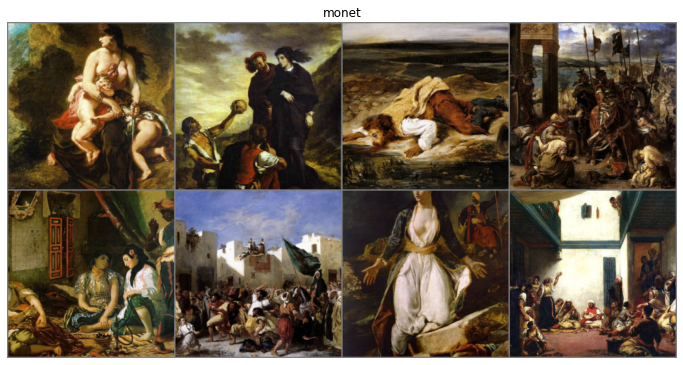

In [139]:
#Check dataset & dataloader results
dataiter = iter(test_dataloader_Y)
images_normalized = dataiter.next()
grid_normalized = make_grid(images_normalized, nrow=4).permute(1, 2, 0).detach().numpy()
grid_original = reverse_normalize(grid_normalized)
fig = plt.figure(figsize=(12, 8))
plt.imshow(grid_original)
plt.axis('off')
plt.title('monet')
plt.show()

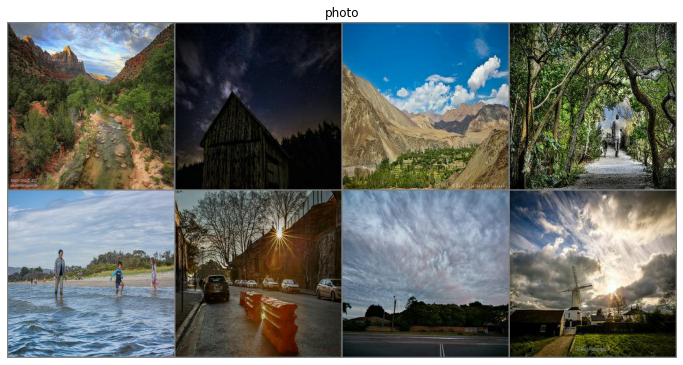

In [18]:
#Check dataset & dataloader results
dataiter = iter(test_dataloader_X)
images_normalized = dataiter.next()
grid_normalized = make_grid(images_normalized, nrow=4).permute(1, 2, 0).detach().numpy()
grid_original = reverse_normalize(grid_normalized)
fig = plt.figure(figsize=(12, 8))
plt.imshow(grid_original)
plt.axis('off')
plt.title('photo')
plt.show()

In [19]:
import torch.nn as nn
import torch.nn.functional as F

def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=False, instance_norm=False):
    """
    Creates a convolutional layer, with optional batch / instance normalization. 
    """
    
    #Add layers
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    layers.append(conv_layer)
    
    #Batch normalization
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    
    #Instance normalization
    if instance_norm:
        layers.append(nn.InstanceNorm2d(out_channels))
    return nn.Sequential(*layers)

In [20]:
class Discriminator(nn.Module):
    
    def __init__(self, conv_dim=64):
        super(Discriminator, self).__init__()
        """
        Input is RGB image (256x256x3) while output is a single value
        
        determine size = [(W−K+2P)/S]+1
        W: input=256
        K: kernel_size=4
        P: padding=1
        S: stride=2
        """
        
        #convolutional layers, increasing in depth
        self.conv1 = conv(in_channels=3, out_channels=conv_dim, kernel_size=4) # (128, 128, 64)
        self.conv2 = conv(in_channels=conv_dim, out_channels=conv_dim*2, kernel_size=4, instance_norm=True) # (64, 64, 128)
        self.conv3 = conv(in_channels=conv_dim*2, out_channels=conv_dim*4, kernel_size=4, instance_norm=True) # (32, 32, 256)
        self.conv4 = conv(in_channels=conv_dim*4, out_channels=conv_dim*8, kernel_size=4, instance_norm=True) # (16, 16, 512)
        self.conv5 = conv(in_channels=conv_dim*8, out_channels=conv_dim*8, kernel_size=4, batch_norm=True) # (8, 8, 512)
        
        #final classification layer
        self.conv6 = conv(conv_dim*8, out_channels=1, kernel_size=4, stride=1) # (8, 8, 1)
    
    def forward(self, x):
        
        #leaky relu applied to all conv layers but last
        out = F.leaky_relu(self.conv1(x), negative_slope=0.2)
        out = F.leaky_relu(self.conv2(out), negative_slope=0.2)
        out = F.leaky_relu(self.conv3(out), negative_slope=0.2)
        out = F.leaky_relu(self.conv4(out), negative_slope=0.2)
#         out = F.leaky_relu(self.conv5(out), negative_slope=0.2)
        
        #classification layer (--> depending on the loss function we might want to use an activation function here, e.g. sigmoid)
        out = self.conv6(out)
        return out

In [21]:
class ResidualBlock(nn.Module):

    def __init__(self, conv_dim):
        super(ResidualBlock, self).__init__()
        """
        Residual blocks help the model to effectively learn the transformation from one domain to another. 
        """
        self.conv1 = conv(in_channels=conv_dim, out_channels=conv_dim, kernel_size=3, stride=1, padding=1, instance_norm=True)
        self.conv2 = conv(in_channels=conv_dim, out_channels=conv_dim, kernel_size=3, stride=1, padding=1, instance_norm=True)
        
    def forward(self, x):
        out_1 = F.relu(self.conv1(x))
        out_2 = x + self.conv2(out_1)
        return out_2

In [22]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=False, instance_norm=False, dropout=False, dropout_ratio=0.5):
    """
    Creates a transpose convolutional layer, with optional batch / instance normalization. Select either batch OR instance normalization. 
    """
    
    #Add layers
    layers = []
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    
    #Batch normalization
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    
    #Instance normalization
    if instance_norm:
        layers.append(nn.InstanceNorm2d(out_channels))
    
    #Dropout
    if dropout:
        layers.append(nn.Dropout2d(dropout_ratio))
    
    return nn.Sequential(*layers)

In [23]:
class CycleGenerator(nn.Module):
    
    def __init__(self, conv_dim=64, n_res_blocks=6):
        super(CycleGenerator, self).__init__()
        """
        Input is RGB image (256x256x3) while output is a single value
        
        determine size = [(W−K+2P)/S]+1
        W: input=256
        K: kernel_size=4
        P: padding=1
        S: stride=2
        """
        
        #Encoder layers
        self.conv1 = conv(in_channels=3, out_channels=conv_dim, kernel_size=4) # (128, 128, 64)
        self.conv2 = conv(in_channels=conv_dim, out_channels=conv_dim*2, kernel_size=4, instance_norm=True) # (64, 64, 128)
        self.conv3 = conv(in_channels=conv_dim*2, out_channels=conv_dim*4, kernel_size=4, instance_norm=True) # (32, 32, 256)
        
        #Residual blocks (number depends on input parameter)
        res_layers = []
        for layer in range(n_res_blocks):
            res_layers.append(ResidualBlock(conv_dim*4))
        self.res_blocks = nn.Sequential(*res_layers)
        
        #Decoder layers
        self.deconv4 = deconv(in_channels=conv_dim*4, out_channels=conv_dim*2, kernel_size=4, instance_norm=True) # (64, 64, 128)
        self.deconv5 = deconv(in_channels=conv_dim*2, out_channels=conv_dim, kernel_size=4, instance_norm=True) # (128, 128, 64)
        self.deconv6 = deconv(in_channels=conv_dim, out_channels=3, kernel_size=4, instance_norm=True) # (256, 256, 3)
        
    def forward(self, x):
        """
        Given an image x, returns a transformed image.
        """
        
        #Encoder
        out = F.leaky_relu(self.conv1(x), negative_slope=0.2) # (128, 128, 64)
        out = F.leaky_relu(self.conv2(out), negative_slope=0.2) # (64, 64, 128)
        out = F.leaky_relu(self.conv3(out), negative_slope=0.2) # (32, 32, 256)
        
        #Residual blocks
        out = self.res_blocks(out)
        
        #Decoder
        out = F.leaky_relu(self.deconv4(out), negative_slope=0.2) # (64, 64, 128)
        out = F.leaky_relu(self.deconv5(out), negative_slope=0.2) # (128, 128, 64)
        out = torch.tanh(self.deconv6(out)) # (256, 256, 3)
        
        return out

In [24]:
from torch.nn import init
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model.
    The weights are taken from a normal distribution with mean = 0, std dev = 0.02.
    Param m: A module or layer in a network    
    """
    #classname will be something like: `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    #normal distribution with given paramters
    std_dev = 0.02
    mean = 0.0
    
    # Initialize conv layer
    if hasattr(m, 'weight') and (classname.find('Conv') != -1):
        init.normal_(m.weight.data, mean, std_dev)

In [25]:
def build_model(g_conv_dim=64, d_conv_dim=64, n_res_blocks=6):
    """
    Builds generators G_XtoY & G_YtoX and discriminators D_X & D_Y 
    """
    
    #Generators
    G_XtoY = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    G_YtoX = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    
    #Discriminators
    D_X = Discriminator(conv_dim=d_conv_dim) # Y-->X
    D_Y = Discriminator(conv_dim=d_conv_dim) # X-->Y
    
    #Weight initialization
    G_XtoY.apply(weights_init_normal)
    G_YtoX.apply(weights_init_normal)
    D_X.apply(weights_init_normal)
    D_Y.apply(weights_init_normal)
    
    #Moves models to GPU, if available
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        G_XtoY.to(device)
        G_YtoX.to(device)
        D_X.to(device)
        D_Y.to(device)
        print('Models moved to GPU.')
    else:
        print('Only CPU available.')

    return G_XtoY, G_YtoX, D_X, D_Y

In [26]:
#Function call
G_XtoY, G_YtoX, D_X, D_Y = build_model()

Models moved to GPU.


In [27]:
#Check model structure
def print_build(G_XtoY, G_YtoX, D_X, D_Y):
    print("                     G_XtoY                    ")
    print("-----------------------------------------------")
    print(G_XtoY)
    print()

    print("                     G_YtoX                    ")
    print("-----------------------------------------------")
    print(G_YtoX)
    print()

    print("                      D_X                      ")
    print("-----------------------------------------------")
    print(D_X)
    print()

    print("                      D_Y                      ")
    print("-----------------------------------------------")
    print(D_Y)
    print()
    
print_build(G_XtoY, G_YtoX, D_X, D_Y)

                     G_XtoY                    
-----------------------------------------------
CycleGenerator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (conv2): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3)

In [28]:
def real_mse_loss(D_out, adverserial_weight=1):
    #how close is the produced output from being "real"?
    mse_loss = torch.mean((D_out-1)**2)*adverserial_weight
    return mse_loss

def fake_mse_loss(D_out, adverserial_weight=1):
    #how close is the produced output from being "false"?
    mse_loss = torch.mean(D_out**2)*adverserial_weight
    return mse_loss

def cycle_consistency_loss(real_img, reconstructed_img, lambda_weight=1):
    reconstr_loss = torch.mean(torch.abs(real_img - reconstructed_img))
    return lambda_weight*reconstr_loss 

def identity_loss(real_img, generated_img, identity_weight=1):
    ident_loss = torch.mean(torch.abs(real_img - generated_img))
    return identity_weight*ident_loss

In [29]:
import torch.optim as optim

#hyperparameter
lr=0.0002 #0.0002
beta1=0.500 #exponential decay rate for the first moment estimates
beta2=0.999 #exponential decay rate for the second-moment estimates
g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())

#Optimizers for generator and discriminator
g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])
d_x_optimizer = optim.Adam(D_X.parameters(), lr, [beta1, beta2])
d_y_optimizer = optim.Adam(D_Y.parameters(), lr, [beta1, beta2])

In [30]:
def training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, n_epochs=1000):
    
    #Losses over time
    losses = []
    
    #Additional weighting parameters (in reality only 2 are required as the third is kind of "given relatively" by the other two)
    adverserial_weight = 0.5
    lambda_weight = 10
    identity_weight = 5
    
    #Get some fixed data from domains X and Y for sampling. Images are held constant throughout training and allow us to inspect the model's performance.
    test_iter_X = iter(test_dataloader_X)
    test_iter_Y = iter(test_dataloader_Y)
    fixed_X = test_iter_X.next()
    fixed_Y = test_iter_Y.next()
    
    # batches per epoch
    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)
    batches_per_epoch = min(len(iter_X), len(iter_Y))
    
    #Average loss over batches per epoch runs
    d_total_loss_avg = 0.0
    g_total_loss_avg = 0.0
    
    #Loop through epochs
    for epoch in range(1, n_epochs+1):
        
        #reset iterators for each epoch
        if epoch % batches_per_epoch == 0:
            iter_X = iter(dataloader_X)
            iter_Y = iter(dataloader_Y)
        
        #Get images from domain X
        images_X = iter_X.next()
        
        #Get images from domain Y
        images_Y = iter_Y.next()
        
        #move images to GPU if available (otherwise stay on CPU)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        images_X = images_X.to(device)
        images_Y = images_Y.to(device)
        
        
        # ============================================
        #            TRAIN THE DISCRIMINATORS
        # ============================================
        
        
        # --------------------------------------------
        ## First: D_X, real and fake loss components
        # --------------------------------------------
        
        # Train with real images
        d_x_optimizer.zero_grad()
        
        # 1. Compute the discriminator losses on real images
        out_x = D_X(images_X)
        D_X_real_loss = real_mse_loss(out_x, adverserial_weight)
        
        # Train with fake images
        # 2. Generate fake images that look like domain X based on real images in domain Y
        fake_X = G_YtoX(images_Y)

        # 3. Compute the fake loss for D_X
        out_x = D_X(fake_X)
        D_X_fake_loss = fake_mse_loss(out_x, adverserial_weight)
        
        # 4. Compute the total loss and perform backpropagation
        d_x_loss = D_X_real_loss + D_X_fake_loss
        d_x_loss.backward()
        d_x_optimizer.step()
        
        # --------------------------------------------
        ## Second: D_Y, real and fake loss components
        # --------------------------------------------
        
        # Train with real images
        d_y_optimizer.zero_grad()
        
        # 1. Compute the discriminator losses on real images
        out_y = D_Y(images_Y)
        D_Y_real_loss = real_mse_loss(out_y, adverserial_weight)
        
        # Train with fake images
        # 2. Generate fake images that look like domain Y based on real images in domain X
        fake_Y = G_XtoY(images_X)
        
        # 3. Compute the fake loss for D_Y
        out_y = D_Y(fake_Y)
        D_Y_fake_loss = fake_mse_loss(out_y, adverserial_weight)
        
        # 4. Compute the total loss and perform backprop
        d_y_loss = D_Y_real_loss + D_Y_fake_loss
        d_y_loss.backward()
        d_y_optimizer.step()
        
        # 5. Compute total discriminator loss
        d_total_loss = D_X_real_loss + D_X_fake_loss + D_Y_real_loss + D_Y_fake_loss
        

        # =========================================
        #            TRAIN THE GENERATORS
        # =========================================
        
        
        # --------------------------------------------
        ## First: generate fake X images and reconstructed Y images
        # --------------------------------------------
        
        #Back to the start
        g_optimizer.zero_grad()
        
        # 1. Generate fake images that look like domain X based on real images in domain Y
        fake_X = G_YtoX(images_Y)
        
        # 2. Compute the generator loss based on domain X
        out_x = D_X(fake_X)
        g_YtoX_loss = real_mse_loss(out_x, adverserial_weight)

        # 3. Create a reconstructed y
        reconstructed_Y = G_XtoY(fake_X)
        
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        reconstructed_y_loss = cycle_consistency_loss(images_Y, reconstructed_Y, lambda_weight=lambda_weight)
        
        # 5. Compute the identity loss from transformation Y-->X
        identity_y_loss = identity_loss(images_Y, fake_X, identity_weight=identity_weight)
        
        # --------------------------------------------
        ## Second: generate fake Y images and reconstructed X images
        # --------------------------------------------
        
        # 1. Generate fake images that look like domain Y based on real images in domain X
        fake_Y = G_XtoY(images_X)
        
        # 2. Compute the generator loss based on domain Y
        out_y = D_Y(fake_Y) #if discriminator believes picture to be from domain Y it returns values cloer to 1, else closer to 0
        g_XtoY_loss = real_mse_loss(out_y, adverserial_weight)
        
        # 3. Create a reconstructed x
        reconstructed_X = G_YtoX(fake_Y)
        
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        reconstructed_x_loss = cycle_consistency_loss(images_X, reconstructed_X, lambda_weight=lambda_weight)
        
        # 5. Compute the identity loss from transformation X-->Y
        identity_x_loss = identity_loss(images_X, fake_Y, identity_weight=identity_weight)
        
        # 6. Add up all generator and reconstructed losses and perform backprop
        g_total_loss = g_YtoX_loss + g_XtoY_loss + reconstructed_y_loss + reconstructed_x_loss + identity_y_loss + identity_x_loss
        g_total_loss.backward()
        g_optimizer.step()
        
        
        # =========================================
        # Admin 
        # =========================================
        
        
        #Average loss
        d_total_loss_avg = d_total_loss_avg + d_total_loss / batches_per_epoch
        g_total_loss_avg = g_total_loss_avg + g_total_loss / batches_per_epoch
        
        # Print log info
        print_every = batches_per_epoch
        if epoch % print_every == 0:
            # append real and fake discriminator losses and the generator loss
            losses.append((d_total_loss_avg.item(), g_total_loss_avg.item()))
            true_epoch_n = int(epoch/batches_per_epoch)
            true_epoch_total = int(n_epochs/batches_per_epoch)
            print('Epoch [{:5d}/{:5d}] | d_total_loss_avg: {:6.4f} | g_total_loss: {:6.4f}'.format(
                    true_epoch_n, true_epoch_total, d_total_loss_avg.item(), g_total_loss_avg.item()))
        
        #Show the generated samples
        show_every = (batches_per_epoch*10)
        if epoch % show_every == 0:
            #set generators to eval mode for image generation
            G_YtoX.eval()
            G_XtoY.eval()
            test_images = show_test(fixed_Y, fixed_X, G_YtoX, G_XtoY)
            #set generators to train mode to continue training
            G_YtoX.train()
            G_XtoY.train()
        
#         #save the model parameters
#         checkpoint_every=3000
#         if epoch % checkpoint_every == 0:
#             save_checkpoint(epoch, G_XtoY, G_YtoX, D_X, D_Y)
    
        #reset average loss for each epoch
        if epoch % batches_per_epoch == 0:
            d_total_loss_avg = 0.0
            g_total_loss_avg = 0.0
    
    return losses

In [54]:
batches_per_epoch = min(len(dataloader_X), len(dataloader_Y))
epoch_true = 1

In [140]:
#n_epochs = epoch_true * batches_per_epoch
n_epochs = 1
print(n_epochs)
losses = training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, n_epochs=n_epochs)

1


IndexError: ignored

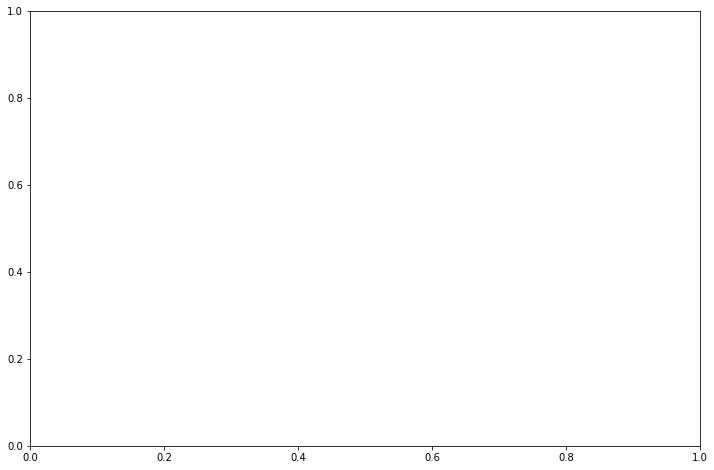

In [57]:
#Plot loss functions over training
fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminators', alpha=0.5)
plt.plot(losses.T[1], label='Generators', alpha=0.5)
plt.title("Training Losses")
plt.legend()
plt.show()

In [141]:
#Get some fixed data from domains X and Y for sampling. These are images that are held constant throughout training, that allow us to inspect the model's performance.
test_iter_X = iter(test_dataloader_X)
test_iter_Y = iter(test_dataloader_Y)

In [76]:
#Sample
fixed_X = test_iter_X.next()
fixed_X = test_iter_X.next()
fixed_X = test_iter_X.next()

#Evaluation
G_XtoY.eval()

mean_=0.5
std_=0.5

#Identify correct device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
#Create fake pictures for both cycles
fake_Y = G_XtoY(fixed_X.to(device))
    
#Generate grids
grid_x =  make_grid(fixed_X, nrow=4).permute(1, 2, 0).detach().cpu().numpy()
grid_fake_y =  make_grid(fake_Y, nrow=4).permute(1, 2, 0).detach().cpu().numpy() 
    
#Normalize pictures to pixel range rom 0 to 255
X, fake_Y_ = reverse_normalize(grid_x, mean_, std_), reverse_normalize(grid_fake_y, mean_, std_)

#Transformation from X -> Y
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(30, 20))
ax1.imshow(X)
ax1.axis('off')
ax1.set_title('X')
ax2.imshow(fake_Y_)
ax2.axis('off')
ax2.set_title('Fake Y, Monet-esque')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [142]:
#Sample
fixed_Y = test_iter_Y.next()
fixed_Y = test_iter_Y.next()
fixed_Y = test_iter_Y.next()

#Evaluation
G_YtoX.eval()

mean_=0.5
std_=0.5

#Identify correct device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
#Create fake pictures for both cycles
fake_X = G_YtoX(fixed_Y.to(device))
    
#Generate grids
grid_y =  make_grid(fixed_Y, nrow=4).permute(1, 2, 0).detach().cpu().numpy()
grid_fake_x =  make_grid(fake_X, nrow=4).permute(1, 2, 0).detach().cpu().numpy()  
    
#Normalize pictures to pixel range rom 0 to 255
Y, fake_X_ = reverse_normalize(grid_y, mean_, std_), reverse_normalize(grid_fake_x, mean_, std_)

#Transformation from Y -> X
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(30, 20))
ax1.imshow(Y)
ax1.axis('off')
ax1.set_title('Y')
ax2.imshow(fake_X_)
ax2.axis('off')
ax2.set_title('Fake X')
plt.show()

Output hidden; open in https://colab.research.google.com to view.